# Visualising The News

## Imports

In [ ]:
!pip install allennlp allennlp-models
!pip install --upgrade google-cloud-storage
!pip install pyLDAvis

In [ ]:
# !python -m spacy download en_core_web_lg

In [8]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pprint import pprint
import itertools
import scipy.stats
import networkx as nx

from allennlp.predictors.predictor import Predictor
from allennlp.data.tokenizers.sentence_splitter import SpacySentenceSplitter
from allennlp.data.tokenizers.spacy_tokenizer import SpacyTokenizer
import spacy
from spacy.matcher import Matcher 

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel, Phrases, phrases, ldamodel, TfidfModel
from gensim.matutils import corpus2dense, corpus2csc
import gensim.downloader as api

import pyLDAvis
import pyLDAvis.gensim_models

from sklearn.cluster import k_means, KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

## Load Models

In [5]:
url = "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2021.03.10.tar.gz"
cf = Predictor.from_path(url)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
downloading: 100%|##########| 1.25G/1.25G [00:47<00:00, 28.2MiB/s]


Downloading:   0%|          | 0.00/414 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/634M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.p

In [ ]:
sp = spacy.load('en_core_web_sm')

In [ ]:
word2vec = api.load('word2vec-google-news-300')

In [12]:
ner_predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/fine-grained-ner.2021-02-11.tar.gz")

downloading: 100%|##########| 359M/359M [00:08<00:00, 45.7MiB/s]
/usr/local/lib/python3.7/dist-packages/allennlp/data/token_indexers/token_characters_indexer.py:60: UserWarning: You are using the default value (0) of `min_padding_length`, which can cause some subtle bugs (more info see https://github.com/allenai/allennlp/issues/1954). Strongly recommend to set a value, usually the maximum size of the convolutional layer size when using CnnEncoder.
  UserWarning,
downloading: 100%|##########| 336/336 [00:00<00:00, 364kiB/s]
downloading: 100%|##########| 357M/357M [00:13<00:00, 26.9MiB/s]
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.

## Load Data

In [13]:
uploaded = files.upload()

Saving airline.csv to airline.csv


In [14]:
data = pd.read_csv('airline.csv', parse_dates=[1])
data.columns = ['url', 'date', 'title', 'author', 'category', 'article']

In [15]:
def get_group_data(category_key, time_key, time_freq):
  categories_df = data.groupby('category')
  cat_key = category_key
  cat_group = categories_df.get_group(cat_key)
  cat_group.reset_index(drop=True, inplace=True)
  time_df = cat_group.groupby(pd.Grouper(key='date', freq=time_freq))
  time_key = time_key
  group = time_df.get_group(time_key)
  group.reset_index(drop=True, inplace=True)
  return group

In [16]:
group = get_group_data('Business', '2021-05-31 00:00:00+0000', '3M')
print(len(group))

48


In [17]:
titles = group['title']
articles = group['article']

In [18]:
def get_intros(articles):
  """Get first 5 sentences from each article """
  sentsplitter = SpacySentenceSplitter() 
  all_sents = sentsplitter.batch_split_sentences(articles)
  intro_sents = [a[:5] for a in all_sents]
  intros = list(map(' '.join, intro_sents))
  return intros

In [ ]:
intros = get_intros(articles)

## Coref Resolution

In [ ]:
coref_intros = [cf.coref_resolved(i) for i in intros]
group['intros'] = coref_intros

## Preprocessing

In [21]:
stopwords_sp = sp.Defaults.stop_words

In [22]:
def clean_text(text):
  """Remove multiple spaces in content"""
  ctext = re.sub(r"\s+", " ", text)
  """Remove ellipsis"""
  ctext = re.sub(r"…", "", ctext)
  """Replace dash between words"""
  ctext = re.sub(r"(?<=\w)-(?=\w)| --", " ", ctext)
  # """Replace punctuation and unwanted chars"""
  # ctext = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\“\”\'\\}{]', '', ctext)

  # text = re.sub(
  #       f"[{re.escape(string.punctuation)}]", "", text
  return ctext

def filter_lemmatise_tokens(tokens):
  filtered_tokens = []
  allowed_postags=['NOUN', 'VERB']

  for token in tokens:
    w = token.text
    if token.pos_ not in allowed_postags or len(w) <= 1 or w in stopwords_sp or w.isdigit():
      continue
    filtered_tokens.append(token.lemma_)
  return filtered_tokens

def get_filtered_tokens(docs):
    tokeniser = SpacyTokenizer()
    tokens_list = [tokeniser.tokenize(d) for d in docs]
    filtered_tokens = [filter_lemmatise_tokens(tokens) for tokens in tokens_list]
    return filtered_tokens

In [ ]:
coref_intros_filt = [clean_text(i) for i in coref_intros]
filtered_tokens = get_filtered_tokens(coref_intros_filt)
print(*filtered_tokens,sep='\n\n')

## K-Means Clustering

In [24]:
def clustering_k_means(X, n_clusters): 
  normalised_data = normalize(X, norm="l2")
  kmeans = KMeans(n_clusters=n_clusters, n_init=25, random_state=0)
  kmeans.fit(X)

  sil_score = silhouette_score(X, kmeans.labels_)
  print("Cluster:" + str(n_clusters) + "sil_score" + str(sil_score))

  return kmeans.labels_, kmeans.cluster_centers_, sil_score

In [25]:
"""Transform the data"""
def transform_data(X, dim):
  pca = PCA(dim)
  transformed_data = pca.fit_transform(X)
  return transformed_data

def visualise_clusters(X, n_clusters):
  cluster_labels, centroids, _ = clustering_k_means(X, n_clusters)
  plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, alpha=0.5, s= 100)
  plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=20, color='red', edgecolor='black')
  plt.show()
  return cluster_labels, centroids

## Word2Vec

In [26]:
def vectorize(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(vector_size)
        vectors = []
        for token in tokens:
            try:
                vectors.append(model[token])
            except KeyError:
                continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [28]:
vector_size = len(word2vec['flight'])
vectorized_intros = np.array(vectorize(filtered_tokens, model=word2vec))
print(vectorized_intros.shape)


opt_cluster_no = 3
transformed_data = np.array(transform_data(vectorized_intros, 2))
print(transformed_data.shape)
k_labels, k_centroids = visualise_clusters(transformed_data, opt_cluster_no)

group['k_clusters'] = k_labels

In [30]:
def n_most_representative_for_cluster(n, t_data, cluster_id, groups, centroids):
    group_indices = np.array(groups.get_group(cluster_id).index.tolist())

    """Can omit clusters with less then m docs"""
    if len(group_indices) < 2:
      return []
    most_representative_indices = np.argsort(
      np.linalg.norm(t_data[group_indices] - centroids[cluster_id], axis=1))[:n]

    return group_indices[most_representative_indices]


def get_cluster_docs(n_most_rep_docs, filtered_tokens, opt_cluster_no, 
                     intro_groups, transformed_data, k_centroids):
  """Get filtered tokens per cluster"""
  cluster_to_docs = {} 
  filtered_tokens_clusters = []
  for cid in range(opt_cluster_no):
      res = n_most_representative_for_cluster(n_most_rep_docs, 
                                              transformed_data, cid, 
                                              intro_groups, k_centroids)
      if len(res) == 0:
        continue
      cluster_to_docs[cid] = res

      #unsure!!!!
      lemmatised_lists = [filtered_tokens[i] for i in res]
      filtered_tokens_clusters.append(list(itertools.chain(*lemmatised_lists)))

  return cluster_to_docs, filtered_tokens_clusters

In [31]:
"""Group by clusters"""
intro_groups = group.groupby(['k_clusters'])

n_most_rep_docs=8
cluster_to_docs, filtered_tokens_clusters = get_cluster_docs(n_most_rep_docs, 
                                                            filtered_tokens, 
                                                            opt_cluster_no, 
                                                            intro_groups, 
                                                            transformed_data, 
                                                            k_centroids)
print(cluster_to_docs)

## LDA

In [32]:
"""Ngrams """

# values change them when more data.

def make_bigrams(token_clusters):
  bigram = gensim.models.Phrases(token_clusters, min_count=3, threshold=4) 
  bigram_model = gensim.models.phrases.Phraser(bigram)
  return [bigram_model[t] for t in token_clusters]

def make_trigrams(token_clusters):
    trigram = gensim.models.Phrases(bigram[token_clusters], threshold=4)  
    trigram_model = gensim.models.phrases.Phraser(trigram)
    return [trigram_model[bigram_model[t]] for t in token_clusters]


def get_lda_params(data_words):
  # Create Dictionary
  lda_dictionary = corpora.Dictionary(data_words) #just using bigrams for now

  # Term Document Frequency
  lda_corpus = [lda_dictionary.doc2bow(text) for text in data_words]

  # # Create the TF-IDF model
  lda_tfidf = TfidfModel(lda_corpus)
  corpus_tfidf = lda_tfidf[lda_corpus]

  return lda_dictionary, corpus_tfidf

In [33]:
# Form Bigrams
data_words_bigrams = make_bigrams(filtered_tokens_clusters)
print(*list(data_words_bigrams), sep='\n')


# Form Trigrams
# data_words_trigrams = make_trigrams(filtered_tokens_clusters)

In [34]:
lda_dictionary, corpus_tfidf = get_lda_params(data_words_bigrams)

# can use multicore
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=lda_dictionary,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5,
                                           minimum_probability = 0.2,
                                           passes=15,
                                           alpha='auto',
                                           per_word_topics=True)

# min prob tuning

In [35]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=lda_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, lda_dictionary, mds='mmds')
pyLDAvis.display(vis)  

In [37]:
def get_topic_cluster_mapping(doc_topics_dist, cluster_to_docs):
  cluster_topic_mapping = zip(cluster_to_docs.keys(), doc_topics_dist)

  # can add this to dataframe after removing rows with omitted clusters (which have less than min no of elements)
  topic_cluster_mapping = {}
  for cid, doc in cluster_topic_mapping:
      """ Just picking one dominant topic"""
      t = sorted(doc[0], key=lambda x: (x[1]), reverse=True)[0][0]
      topic_cluster_mapping.setdefault(t, []).append(cid)
  
  return topic_cluster_mapping

def get_topic_doc_mapping(topic_cluster_mapping, lda_model, cluster_to_docs):
  keywords = []
  topics_to_docs = {}
  for t, cs in topic_cluster_mapping.items():
      topic_keywords = ", ".join([w for w, p in lda_model.show_topic(t)])
      keywords.append(topic_keywords)
      docs = [cluster_to_docs.get(cid) for cid in cs]
      docs = list(itertools.chain(*docs))
      topics_to_docs[t] = docs

  topics_df = pd.DataFrame(list(topic_cluster_mapping.items()), columns = ['TopicId','Clusters'])
  topics_df['Keywords'] = keywords
  return topics_df, topics_to_docs

In [38]:
doc_topics_dist = lda_model[corpus_tfidf]
topic_cluster_mapping = get_topic_cluster_mapping(doc_topics_dist, cluster_to_docs)
topics_df, topics_to_docs = get_topic_doc_mapping(topic_cluster_mapping, lda_model, cluster_to_docs)
pprint(topics_df)
pprint(topics_to_docs)

## NER + Coocurrence

In [62]:
def remove_stopwords(text, stopwords):
  str_stopwords = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
  c = re.sub(str_stopwords, ' ', text)
  c = re.sub(r"\s+", " ", c)
  return c

def get_entities(result):
  entities = set()
  ignore_types = ['DATE', 'TIME', 'CARDINAL', 'PERCENT', 'QUANTITY']
  for word, tag in zip(result["words"], result["tags"]):
      if tag == "O":
        continue
      ent_position, ent_type = tag.split("-")
      if ent_type in ignore_types:
        continue
      if ent_position == "U":
        entities.add(word)
      else:
        if ent_position == "B":
            e = word
        elif ent_position == "I":
            e += " " + word
        elif ent_position == "L":
            e += " " + word
            entities.add(e)

  return entities

def get_cooccurences(doc, col, sp_model, ner_pred):
  c_sents = []
  for s in sp_model(doc).sents:
    if len(s) < 3:
      continue
    ents = list(get_entities(ner_pred.predict(sentence=s.text.strip())))
    # get permuatations instead?
    if len(ents) != 2:
      continue
    c_sents.append((ents[0], ents[1], col))
  return c_sents

In [162]:
def get_data_triples(topics_to_docs, coref_intros, stopwords, function, *args):
  df_data = []
  colours= ['black', 'red', 'green', 'blue', 'yellow']
  topic_colouring = dict(zip(topics_to_docs.keys(), colours))

  for t, docs in topics_to_docs.items():
    rels = [function(remove_stopwords(clean_text(coref_intros[d]), stopwords), topic_colouring[t], *args) for d in docs]
    df_data.append(itertools.chain(*rels))

  df_data = itertools.chain(*df_data)
  
  if function.__name__ == "get_cooccurences":
    df_triples = pd.DataFrame(df_data, columns=['subject', 'objects', 'color'])
  else: 
    df_triples = pd.DataFrame(df_data, columns=['subject', 'relation', 'objects', 'color'])

  return df_triples

def draw_kg(pairs, show_rels=True):
  k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'objects',create_using=nx.MultiDiGraph(), edge_attr='color')
  node_deg = nx.degree(k_graph)
  layout = nx.spring_layout(k_graph, k=1, iterations=60)
  plt.figure(figsize=(35,30))
  nx.draw_networkx(
      k_graph,
      node_size=[int(deg[1]) * 1000 for deg in node_deg],
      linewidths=1.5,
      pos=layout,
      edge_color=nx.get_edge_attributes(k_graph,'color').values(),
      edgecolors='black',
      node_color='white',
      )
  if show_rels:
    labels = dict(zip(list(zip(pairs.subject, pairs.objects)),pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,font_color='black')
  plt.show()

In [ ]:
all_rels_df = get_data_triples(topics_to_docs, coref_intros, stopwords_sp, get_cooccurences, sp, ner_predictor)

|    | subject                                | objects                                   | color   |
|---:|:---------------------------------------|:------------------------------------------|:--------|
|  0 | $ 20 million                           | U.S.                                      | black   |
|  1 | Mexico                                 | Interjet                                  | black   |
|  2 | London Stansted Airport                | Ryanair                                   | black   |
|  3 | Johnson                                | U.K. Parliament                           | black   |
|  4 | Air France KLM                         | Schiphol Airport                          | black   |
|  5 | Mumbai                                 | Chhatrapati Shivaji International Airport | black   |
|  6 | India                                  | Bloomberg                                 | black   |
|  7 | Moscow St. Petersburg                  | European                          

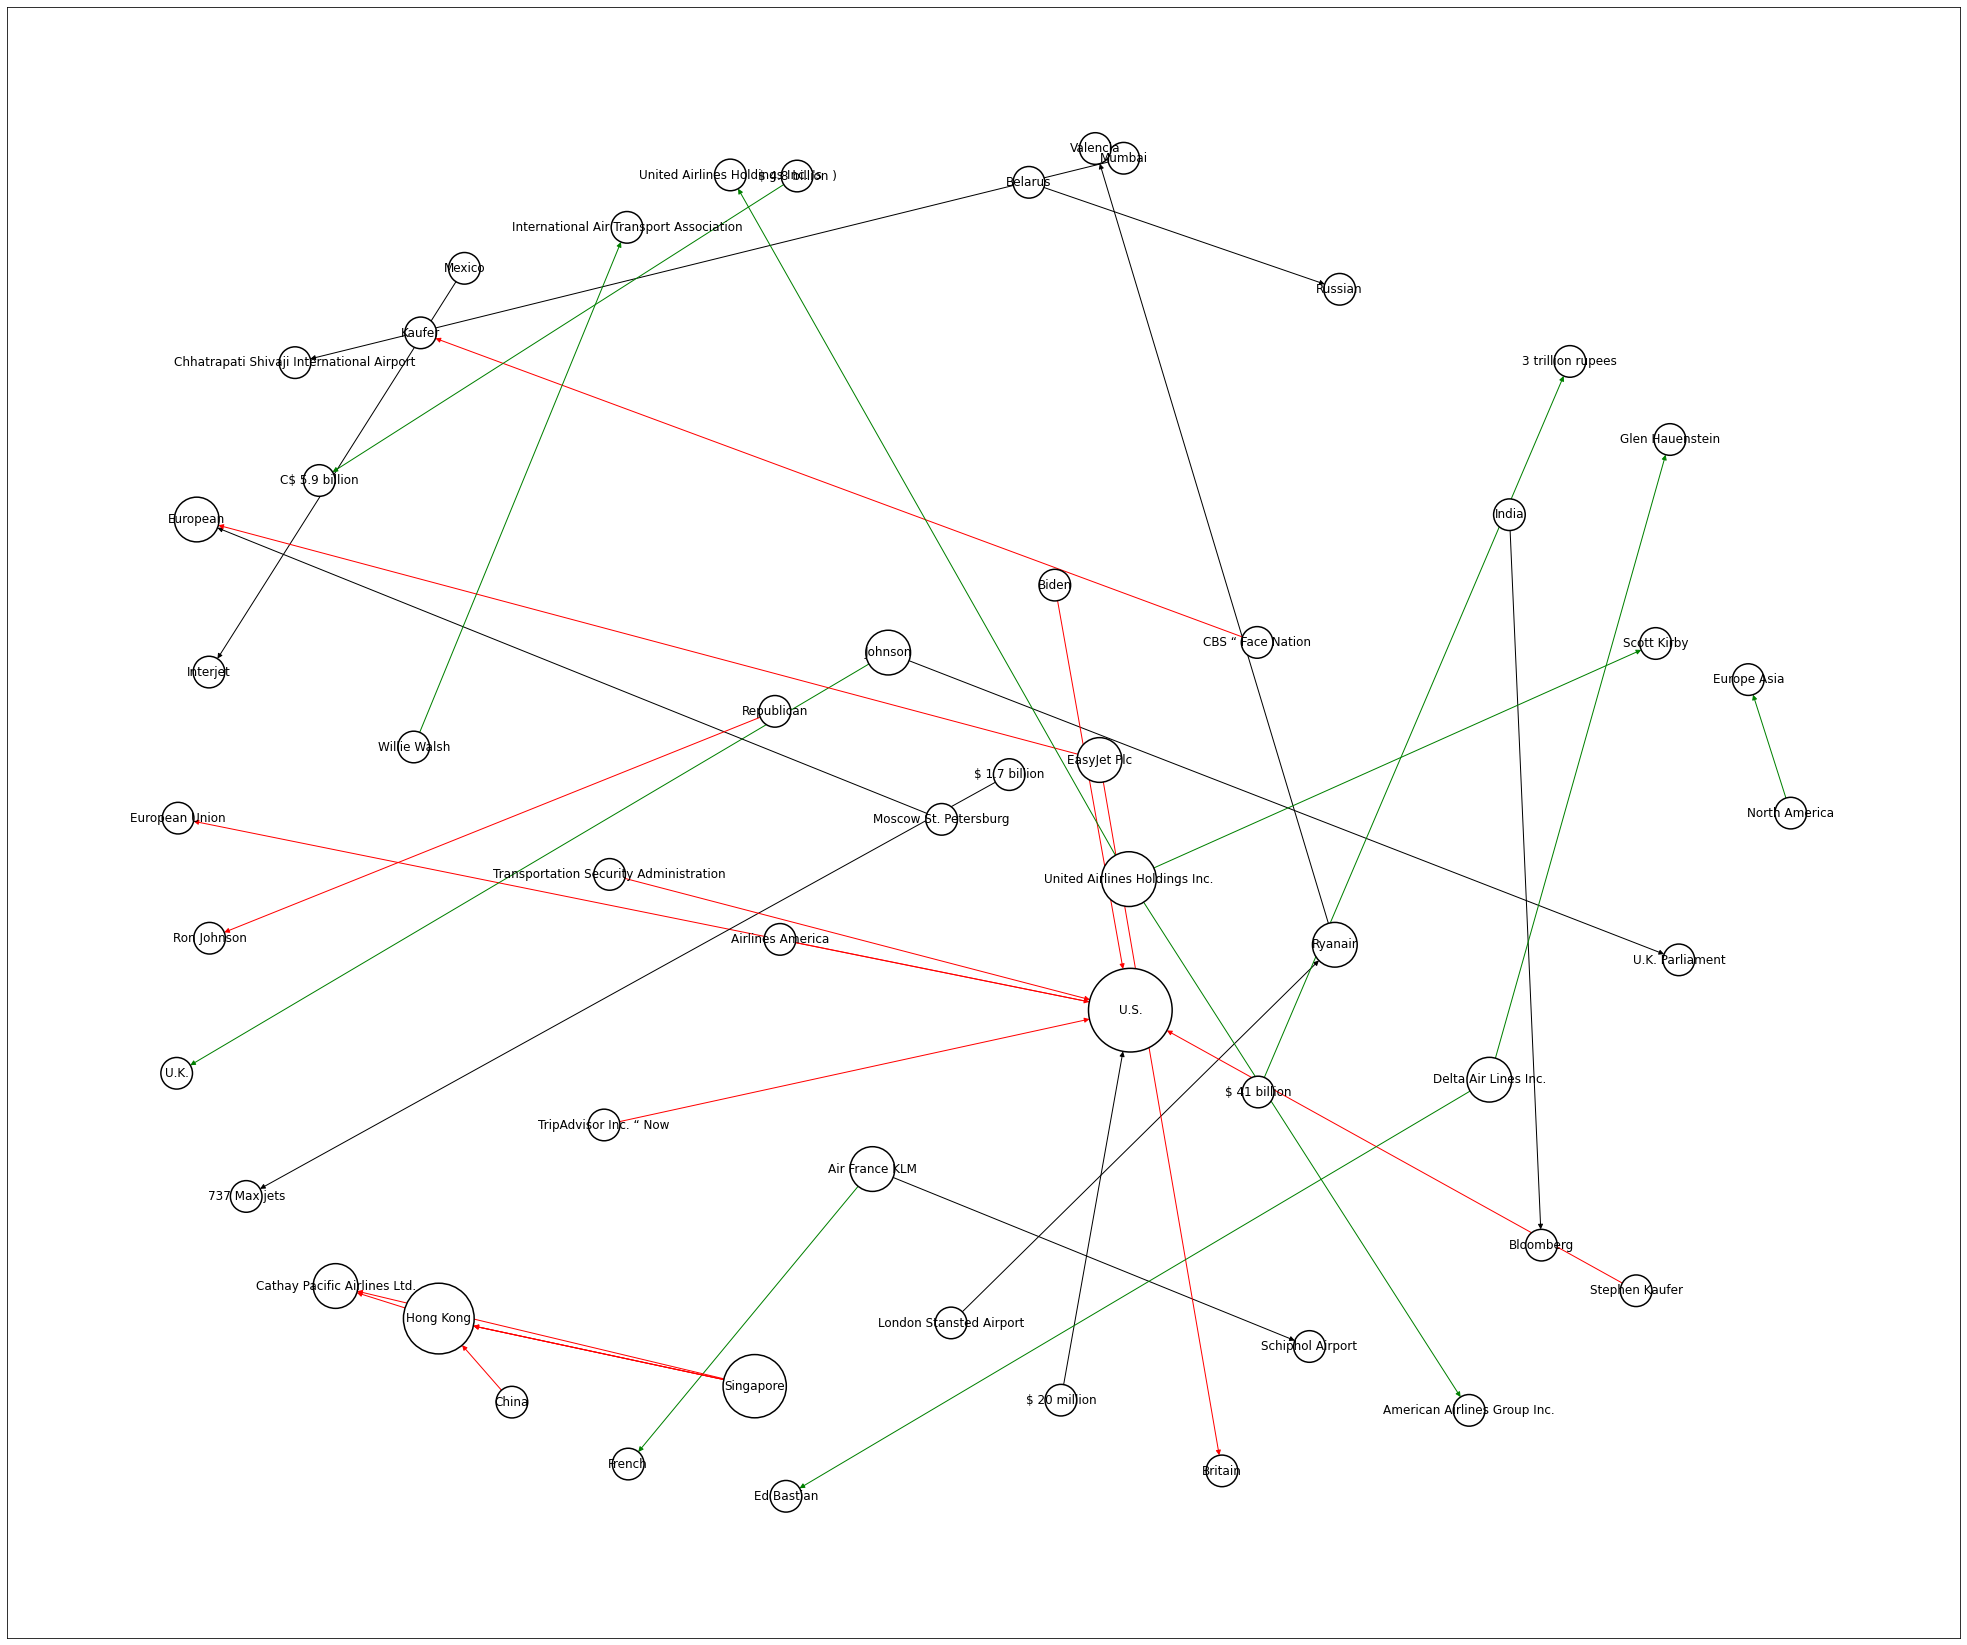

In [164]:
print(all_rels_df.to_markdown())
draw_kg(all_rels_df, show_rels=False)

# Relation Extraction

## Method 1 - entity relations

In [174]:
def get_relation(sent, sp_model):
    doc = sp_model(sent)
    matcher = Matcher(sp_model.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern], on_match=None)

    matches = matcher(doc)
    print(matches)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return span.text

def get_entity_triples(doc, col, sp_model, ner_pred):
  triples = []
  for s in sp_model(doc).sents:
    if len(s) < 3:
      continue
    s = s.text.strip()
    ents = list(get_entities(ner_pred.predict(sentence=s)))
    if len(ents) != 2:
      continue
    rel = get_relation(s, sp_model)
    if not rel or rel.strip() in ["told", "said", "saying", "tell", "say"]:
      continue
    triples.append((ents[0], rel, ents[1], col))

  return triples

In [ ]:
df_triples_m1 = get_data_triples(topics_to_docs, coref_intros, stopwords_sp, get_entity_triples, sp, ner_predictor)

|    | subject                                | relation          | objects                                   | color   |
|---:|:---------------------------------------|:------------------|:------------------------------------------|:--------|
|  0 | $ 20 million                           | raise             | U.S.                                      | black   |
|  1 | Mexico                                 | Interjet          | Interjet                                  | black   |
|  2 | London Stansted Airport                | Airport           | Ryanair                                   | black   |
|  3 | Johnson                                | Wins              | U.K. Parliament                           | black   |
|  4 | Air France KLM                         | operated          | Schiphol Airport                          | black   |
|  5 | Mumbai                                 | Mumbai            | Chhatrapati Shivaji International Airport | black   |
|  6 | India            

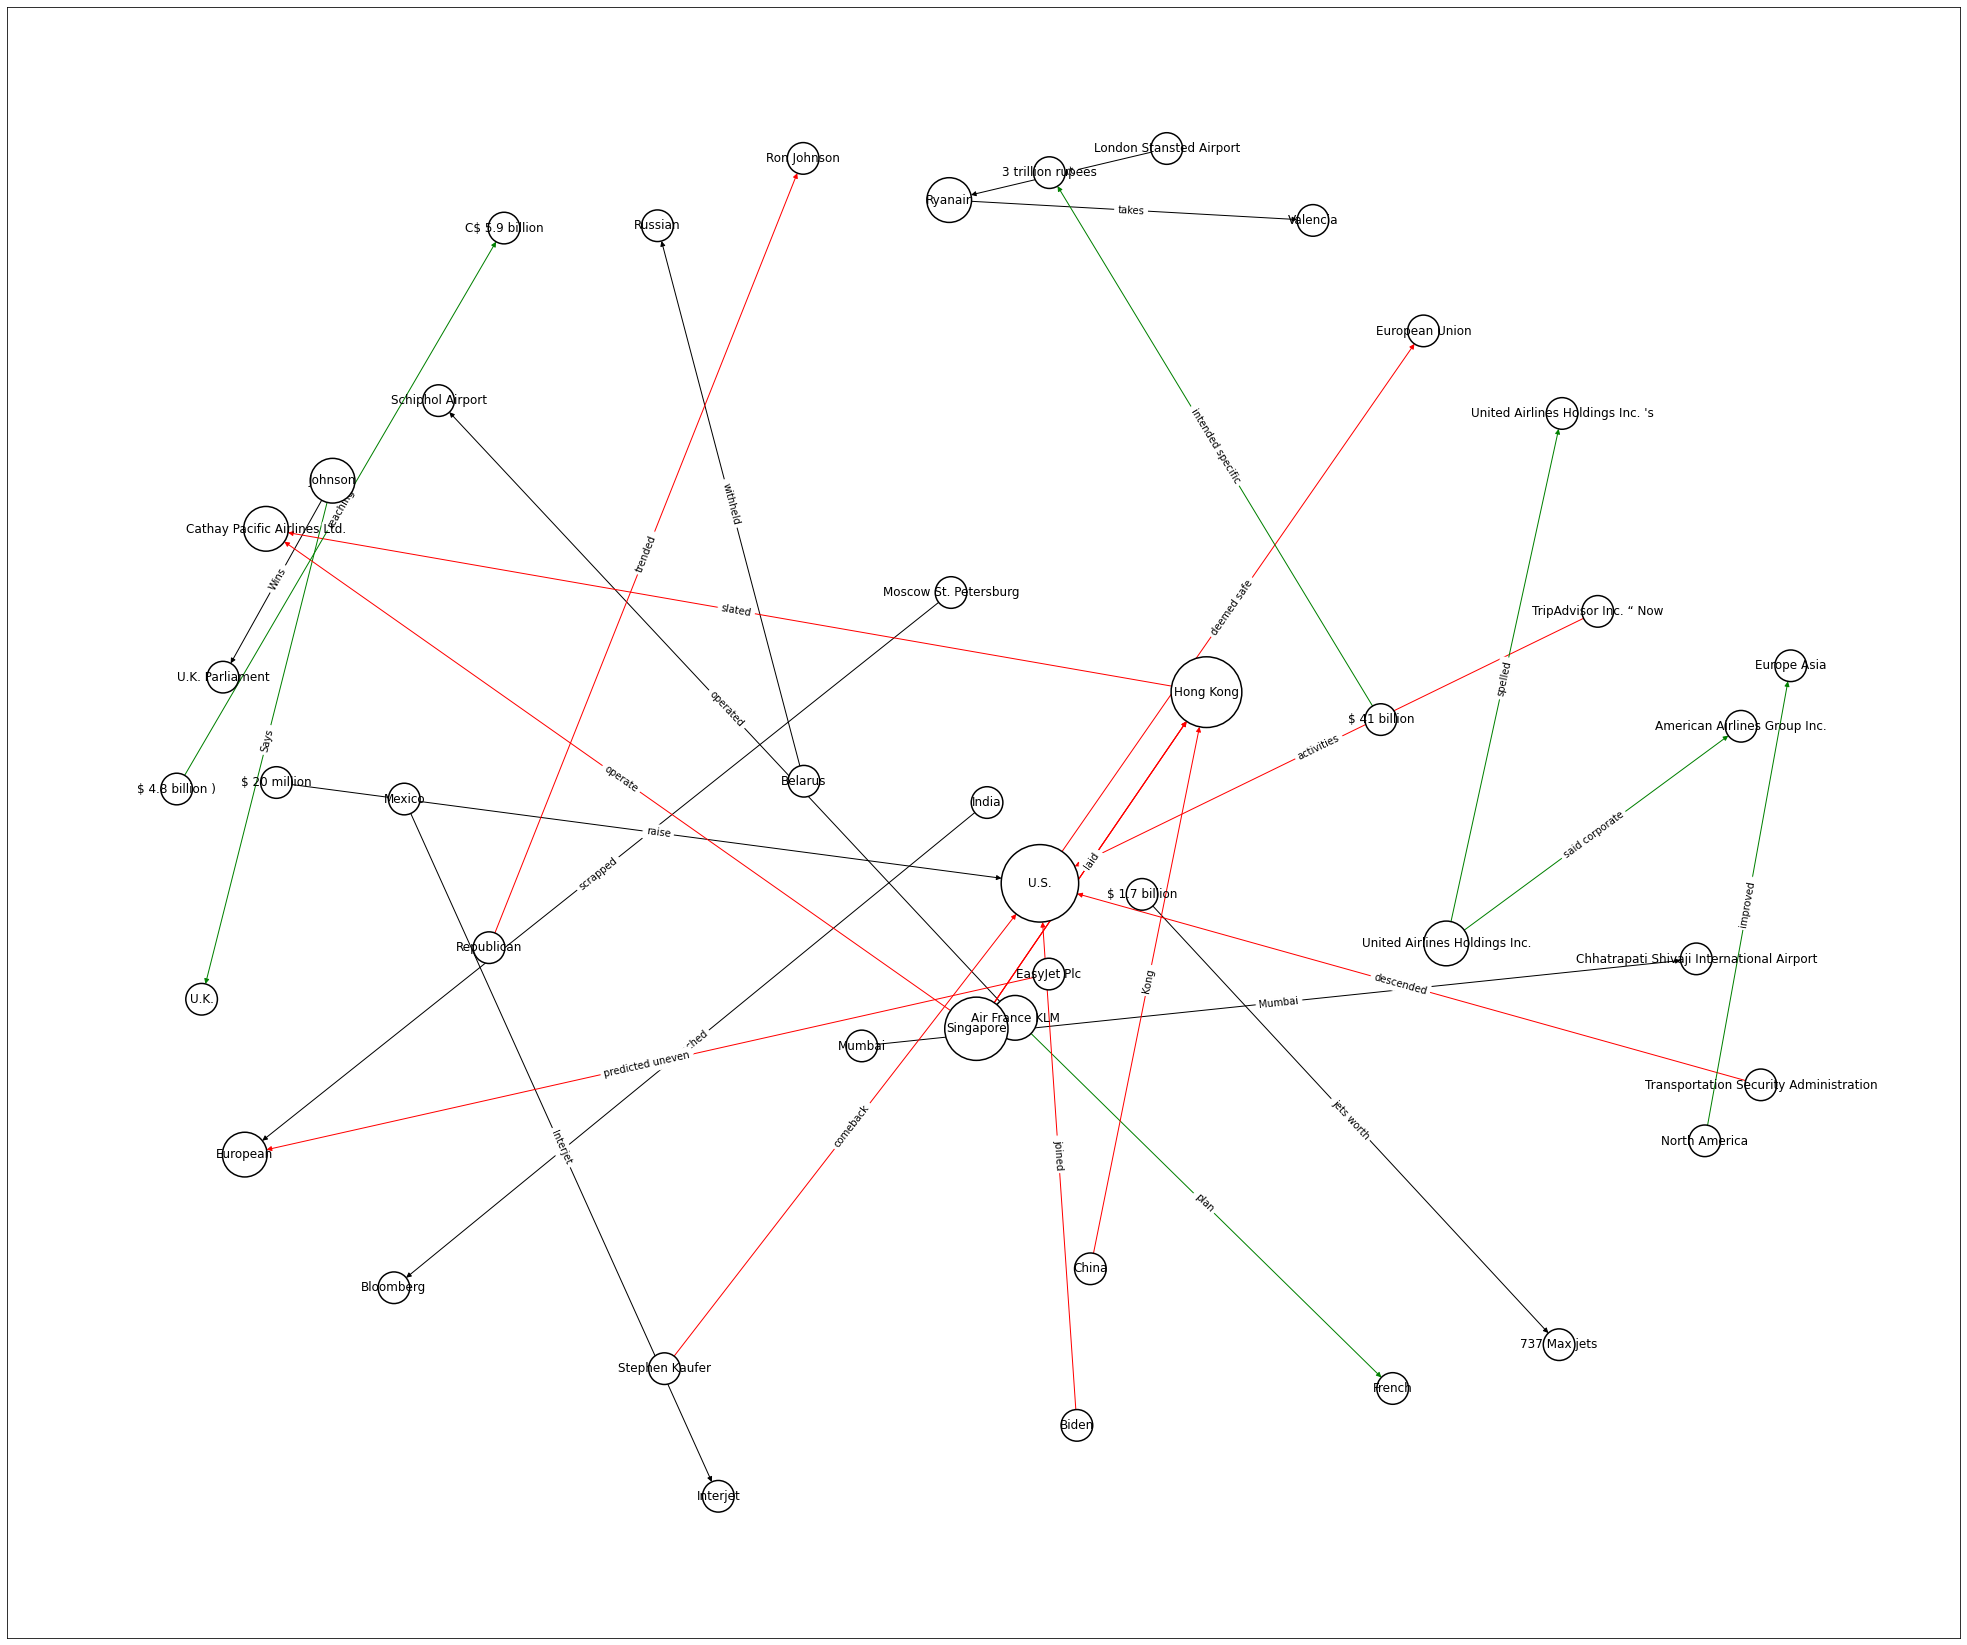

In [176]:
print(df_triples_m1.to_markdown())
draw_kg(df_triples_m1, show_rels=True)

## Method 2

In [168]:
def find_longest_common_substring(s1, s2):
  lcs = ""
  len1, len2 = len(s1), len(s2)
  for i in range(len1):
      match = ""
      for j in range(len2):
          if i + j < len1 and s1[i + j] == s2[j]:
              match += s2[j]
          else:
              if len(match) > len(lcs): lcs = match
              match = ""
      if len(match) > len(lcs): lcs = match 
  return lcs

from itertools import islice

def is_sublist(source, target):
    slen = len(source)
    return any(all(item1 == item2 for (item1, item2) in zip(source, islice(target, i, i+slen))) for i in range(len(target) - slen + 1))

def long_substr_by_word(data):
    subseq = []
    data_seqs = [s.split(' ') for s in data]
    if len(data_seqs) > 1 and len(data_seqs[0]) > 0:
        for i in range(len(data_seqs[0])):
            for j in range(len(data_seqs[0])-i+1):
                if j > len(subseq) and all(is_sublist(data_seqs[0][i:i+j], x) for x in data_seqs):
                    subseq = data_seqs[0][i:i+j]
    return ' '.join(subseq)

In [192]:
def refine_ent(ent, sent, sp_model):
  unwanted_tokens = (
      'PRON',  # pronouns
      'PART',  # particle
      'DET',  # determiner
      'SCONJ',  # subordinating conjunction
      'PUNCT',  # punctuation
      'SYM',  # symbol
      'X',  # other
  )
  ent_type = ent.ent_type_  # get entity type
  if ent_type == '':
      ent_type = 'NOUN_CHUNK'
      ent = ' '.join(str(t.text) for t in sp_model(str(ent)) if t.pos_ not in unwanted_tokens and t.is_stop == False)
      
  elif ent_type in ('CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
      refined = ''
      for i in range(len(sent) - ent.i):
          if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
              refined += ' ' + str(ent.nbor(i))
          else:
              ent = refined.strip()
              break

  return ent, ent_type

def filter_triples(triples):
  filtered_triples = []
  for (s, r, o, c) in triples:
    if not all((s, r, o, c)) or s == o or r.strip() in ["told", "said", "saying", "tell", "say"]:
      continue
    lcs = long_substr_by_word([s,o])
    if (len(lcs)> 3):
      print("before s:", s)
      print("before o:", o)
      print('lcs%s' % lcs)

      o = o.replace(lcs, '').strip()
      print("after:", o)


    filtered_triples.append((s, r, o, c))
  return filtered_triples

def extract_relations(doc, col, sp_model):
  ent_pairs = []
  for s in sp(doc).sents:
    sent = s.text.strip()
    sent = sp(sent)

    spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
    spans = spacy.util.filter_spans(spans)
    with sent.retokenize() as retokenizer:
        [retokenizer.merge(span, attrs={'tag': span.root.tag,
                                        'dep': span.root.dep}) for span in spans]
          
          
    # deps = [token.dep_ for token in sent]
    # cond =  (deps.count('obj') + deps.count('dobj')) != 1\
    #             or (deps.count('subj') + deps.count('nsubj')) != 1
    # if cond:
    #         continue

    for token in sent:
      if token.dep_ not in ('obj', 'dobj'):  # identify object nodes
          continue
      subject = [w for w in token.head.lefts if w.dep_
                  in ('subj', 'nsubj')]  # identify subject nodes
      if subject:
          subject = subject[0]
          # identify relationship by root dependency
          relation = [w for w in token.ancestors if w.dep_ == 'ROOT']
          if relation:
              relation = relation[0]
              # add adposition or particle to relationship
              if relation.i < len(sent) - 1 and relation.nbor(1).pos_ in ('ADP', 'PART'):
                  relation = ' '.join((str(relation), str(relation.nbor(1))))
          else:
              continue

          subject, subject_type = refine_ent(subject, sent, sp_model)
          obj, object_type = refine_ent(token, sent, sp_model)

          ent_pairs.append((str(subject), str(relation), str(obj), col))
    
    ent_pairs = [sublist for sublist in ent_pairs if not any(str(ent) == '' for ent in sublist)]
    filtered_triples = filter_triples(ent_pairs)
  return filtered_triples

In [ ]:
df_triples_m2 = get_data_triples(topics_to_docs, coref_intros, stopwords_sp, extract_relations, sp)

|    | subject                                                     | relation           | objects                                                                        | color   |
|---:|:------------------------------------------------------------|:-------------------|:-------------------------------------------------------------------------------|:--------|
|  0 | Air Hf                                                      | worked             | Wow                                                                            | black   |
|  1 | new airline planning rapid listing                          | raise              | 20 million fund U.S. routes                                                    | black   |
|  2 | Dublin                                                      | followed           | AerCap Holdings NV                                                             | black   |
|  3 | latest setbacks                                             | return             | air t

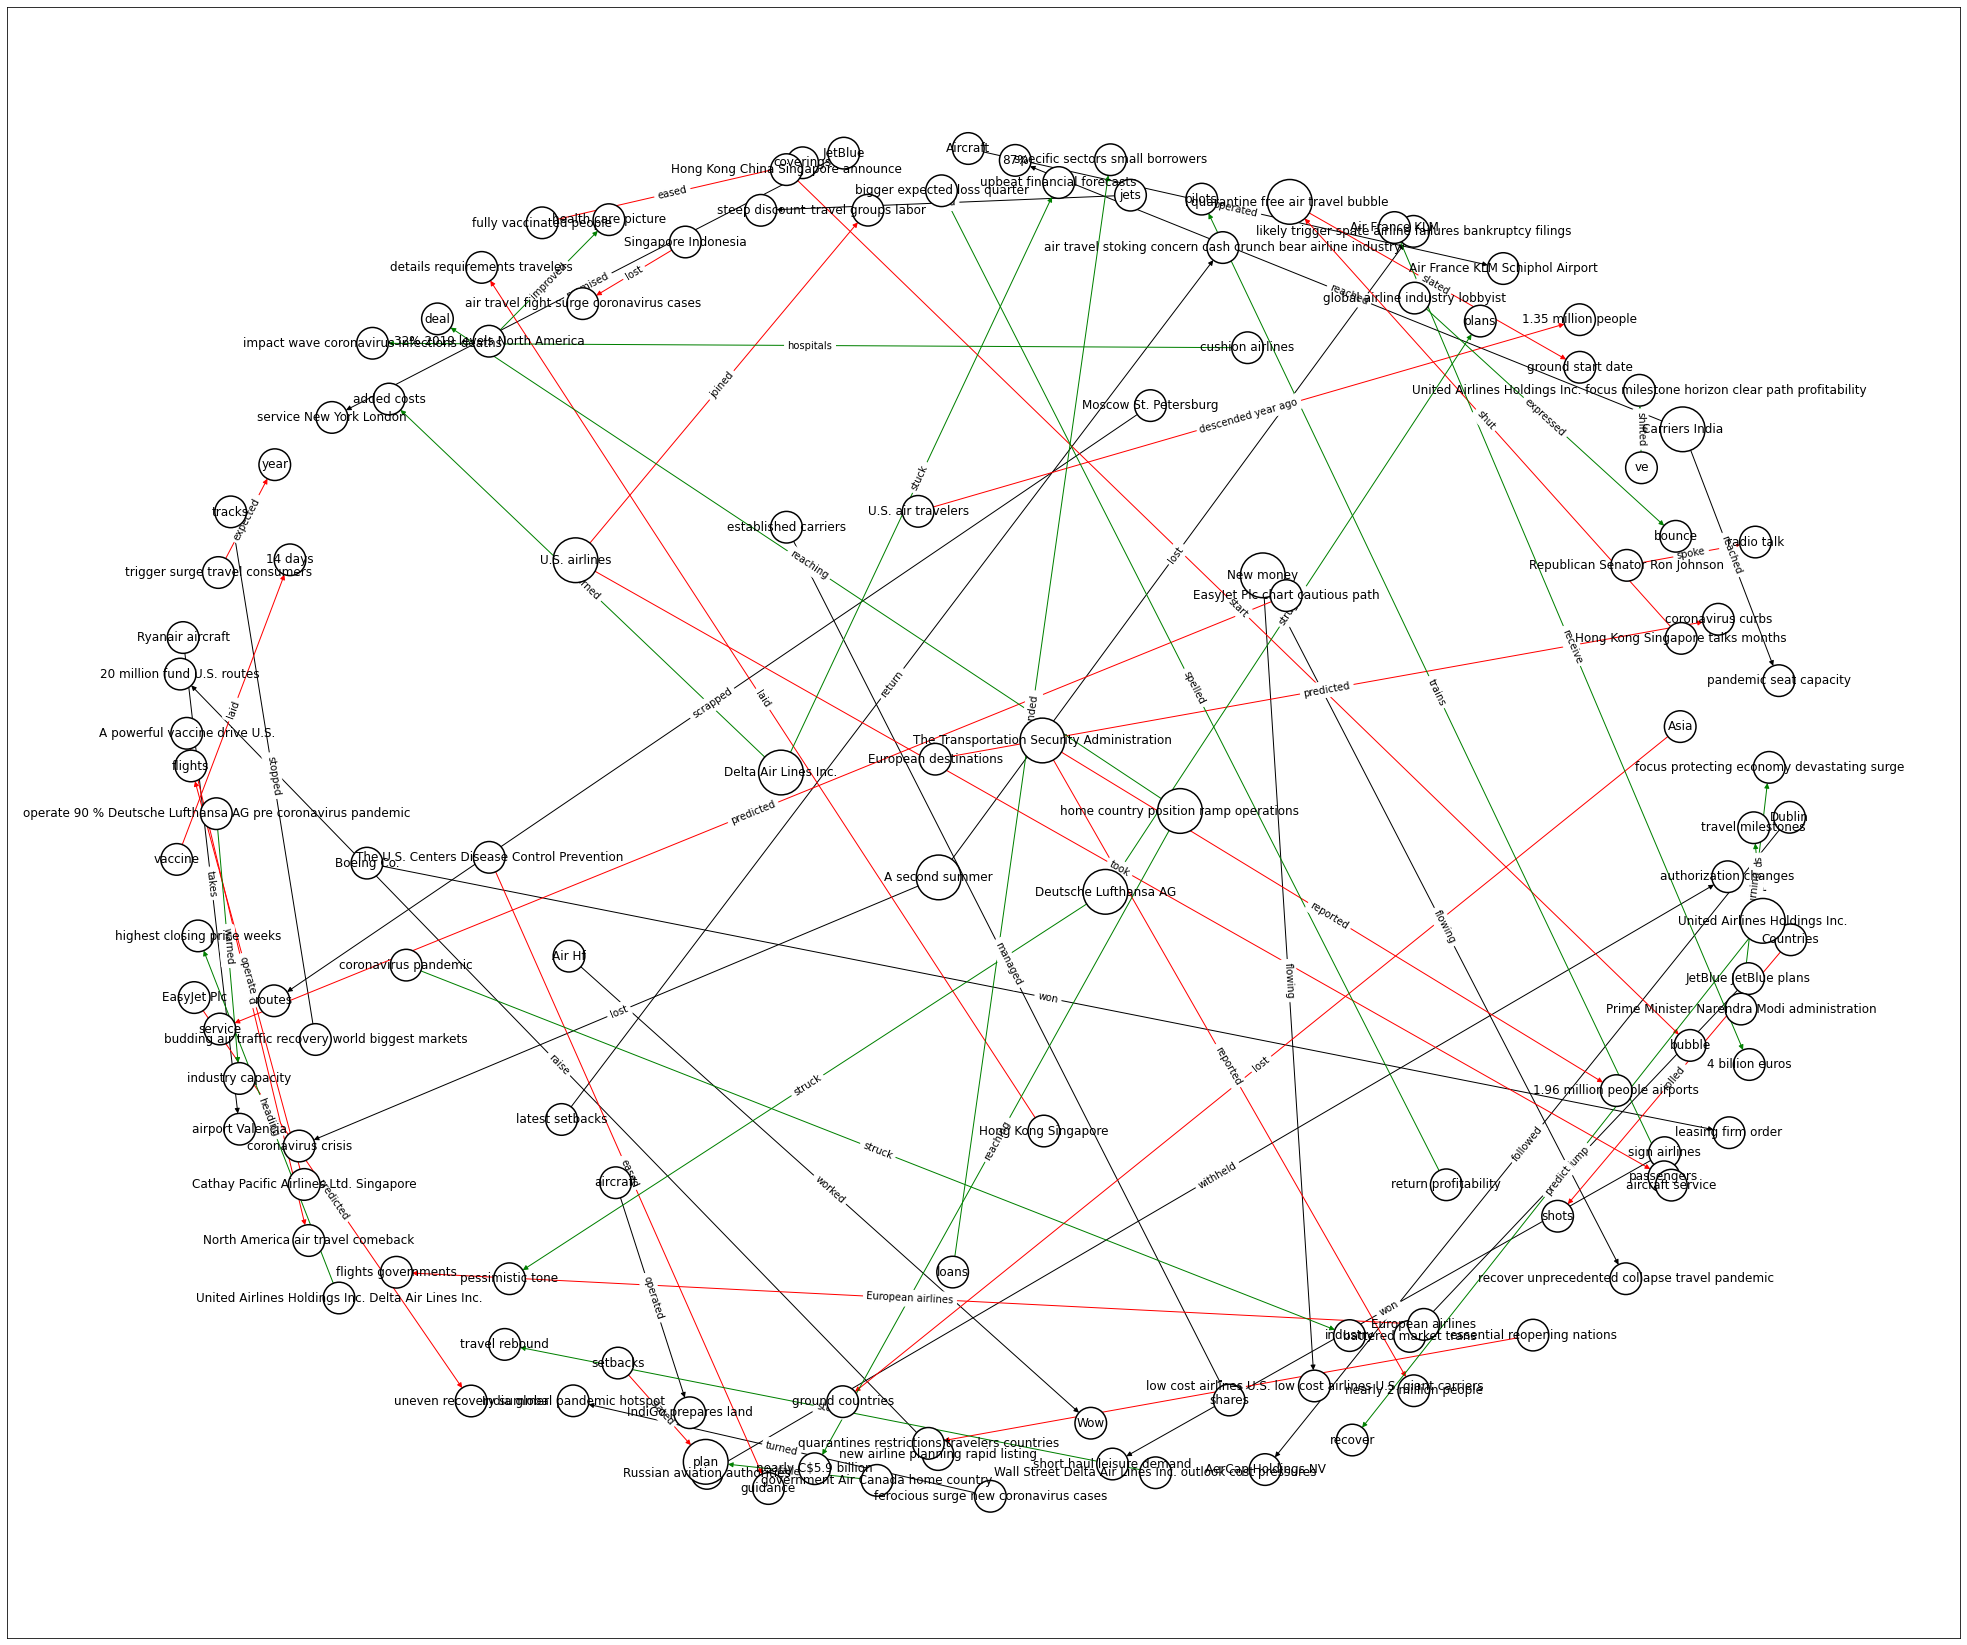

In [170]:
print(df_triples_m2.to_markdown())
draw_kg(df_triples_m2, show_rels=True)

## Method 3

In [158]:
# verb_patterns = [[{"POS":"AUX"}, {"POS":"VERB"}, 
#                   {"POS":"ADP"}], 
#                  [{"POS":"AUX"}],
#                  [{"POS":"VERB"}]]
verb_patterns = [[{'POS': 'VERB', 'OP': '?'},
           {'POS': 'ADV', 'OP': '*'},
           {'POS': 'VERB', 'OP': '+'}], [{"POS":"VERB"}]]
def find_root_of_sentence(doc):
    root_token = None
    for token in doc:
        if (token.dep_ == "ROOT"):
            root_token = token
    return root_token

def contains_root(verb_phrase, root):
    vp_start = verb_phrase.start
    vp_end = verb_phrase.end
    if (root.i >= vp_start and root.i <= vp_end):
        return True
    else:
        return False

def get_verb_phrases(doc, sp_model):
    root = find_root_of_sentence(doc)
    matcher = Matcher(sp_model.vocab) 
    matcher.add("verb-phrases", verb_patterns)
    matches = matcher(doc)
    verb_phrases = [doc[start:end] for _, start, end in matches] 
    new_vps = []
    for verb_phrase in verb_phrases:
        if (contains_root(verb_phrase, root)):
            new_vps.append(verb_phrase)
    return new_vps

def longer_verb_phrase(verb_phrases):
    longest_length = 0
    longest_verb_phrase = None
    for verb_phrase in verb_phrases:
        if len(verb_phrase) > longest_length:
            longest_verb_phrase = verb_phrase
    return longest_verb_phrase

def find_noun_phrase(verb_phrase, noun_phrases, side):
    for noun_phrase in noun_phrases:
        if (side == "left" and \
            noun_phrase.start < verb_phrase.start):
            return noun_phrase.text.strip()
        elif (side == "right" and \
              noun_phrase.start > verb_phrase.start):
            return noun_phrase.text.strip()
  
def find_triplet(doc, col, sp_model):
  triples = []
  for s in sp_model(doc).sents:
    sent = sp_model(s.text.strip())
    verb_phrases = get_verb_phrases(sent, sp_model)
    if len(verb_phrases) == 0:
      continue

    noun_phrases = sent.noun_chunks

    verb_phrase = None
    if (len(verb_phrases) > 1):
        verb_phrase = longer_verb_phrase(list(verb_phrases))
    else:
        verb_phrase = verb_phrases[0]

    left_noun_phrase = find_noun_phrase(verb_phrase, noun_phrases, "left")
    right_noun_phrase = find_noun_phrase(verb_phrase, noun_phrases, "right")
  
    triples.append((left_noun_phrase, verb_phrase.text, right_noun_phrase, col))

  filtered_triples = filter_triples(triples)

  return filtered_triples

In [ ]:
df_triples_m3 = get_data_triples(topics_to_docs, coref_intros, stopwords_sp, find_triplet, sp)

|    | subject                                                         | relation            | objects                                                                          | color   |
|---:|:----------------------------------------------------------------|:--------------------|:---------------------------------------------------------------------------------|:--------|
|  0 | seeks                                                           | comes               | new airline                                                                      | black   |
|  1 | Air Hf                                                          | having worked       | Wow                                                                              | black   |
|  2 | new airline planning rapid listing                              | raise               | $20 million fund U.S. routes                                                     | black   |
|  3 | single Airbus SE A321neo narrow body                 

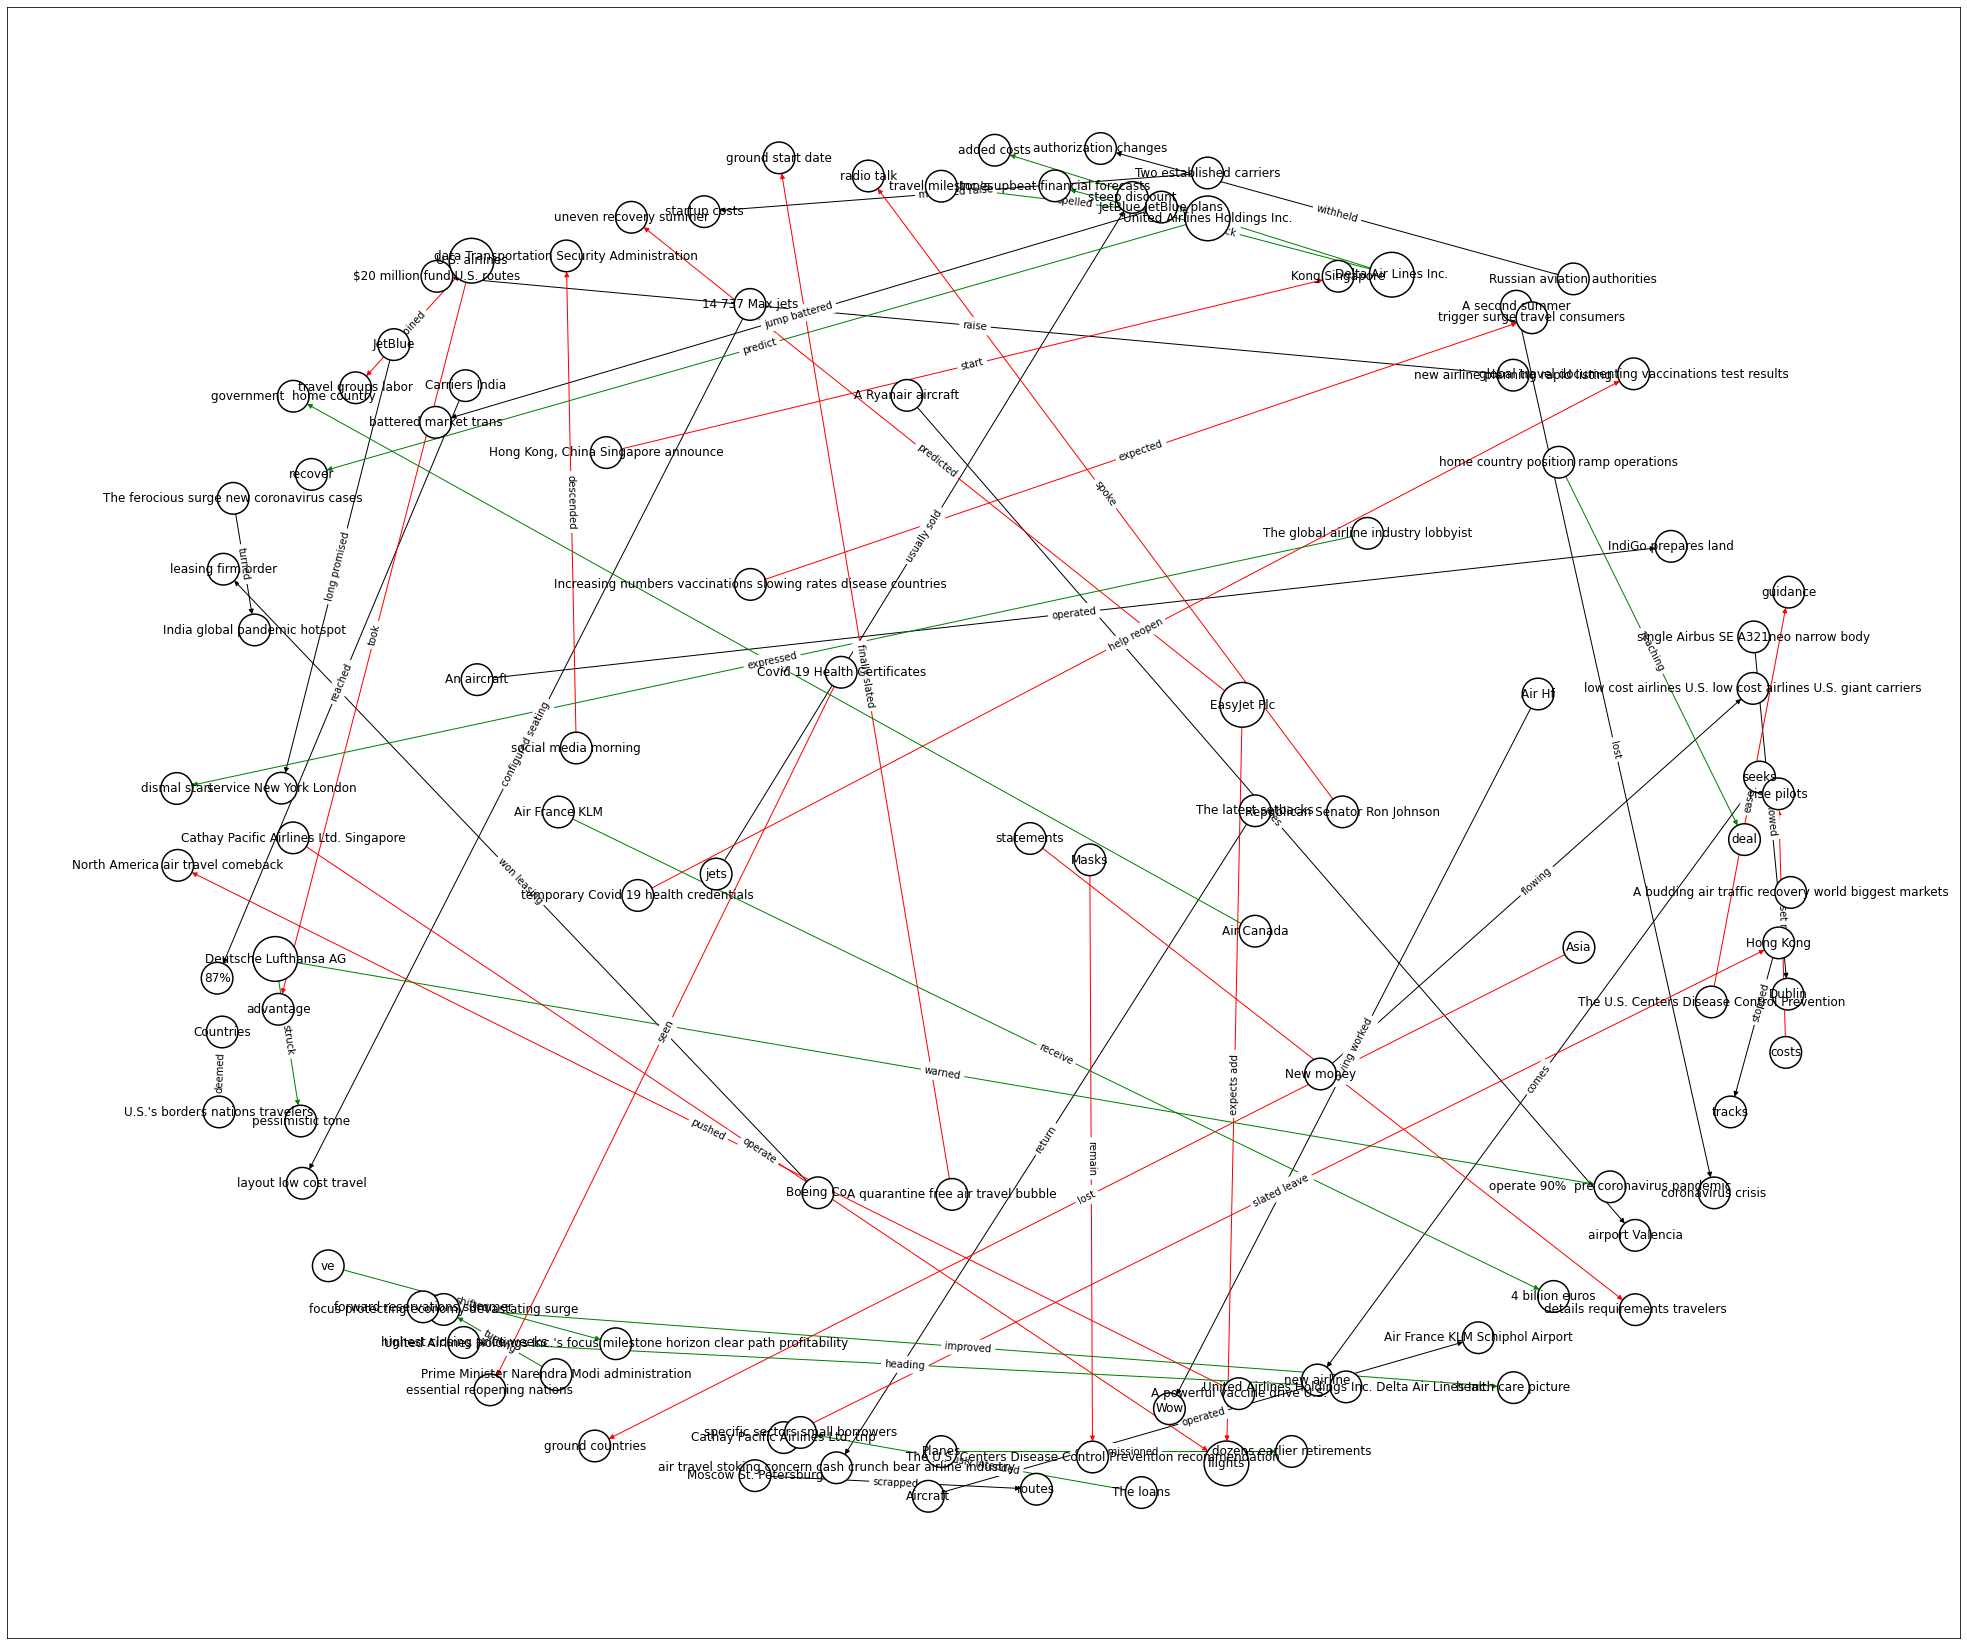

In [172]:
print(df_triples_m3.to_markdown())
draw_kg(df_triples_m3, show_rels=True)